In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [5]:
dataframe = pd.read_csv("cleaned_dataset_with_credibility_and_significant_length_features.csv")

In [6]:
# Print the shape of the dataframe
print(f"Dataset shape: {dataframe.shape}")
dataframe.head()

Dataset shape: (2035, 20)


,author,title,text,site_url,label,language,enhanced_source_credibility_score,enhanced_author_credibility_score,title_length_of_characters,title_word_count,text_length_of_characters,text_word_count,text_average_word_length,text_average_sentence_length,title_length_of_characters_zscore,title_word_count_zscore,text_length_of_characters_zscore,text_word_count_zscore,text_average_word_length_zscore,text_average_sentence_length_zscore
0,Barracuda Brigade,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,100percentfedup.com,Real,english,95.28177,85.755236,51,8,492,86,4.697674,86.0,-0.335078,-0.389929,-0.657936,-0.643134,-0.386320,-0.646573
1,reasoning with facts,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,100percentfedup.com,Real,english,95.28177,82.226429,57,10,1720,273,5.274725,273.0,-0.151628,-0.014127,-0.333042,-0.349978,0.183172,-0.346563
2,Barracuda Brigade,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,100percentfedup.com,Real,english,95.28177,85.755236,67,9,1323,222,4.932432,222.0,0.154122,-0.202028,-0.438077,-0.429930,-0.154637,-0.428384
3,Fed Up,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,100percentfedup.com,Real,english,95.28177,88.238767,115,20,262,48,4.479167,48.0,1.621724,1.864880,-0.718788,-0.702706,-0.601966,-0.707538
4,Fed Up,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,100percentfedup.com,Real,english,95.28177,88.238767,90,12,2047,327,5.232416,327.0,0.857348,0.361674,-0.246527,-0.265323,0.141417,-0.259929


In [7]:
# Check language distribution
language_counts = dataframe["language"].value_counts()
print("\nLanguage distribution in the dataset:")
print(language_counts)


Language distribution in the dataset:
language
english    1957
german       72
ignore        3
french        2
spanish       1
Name: count, dtype: int64


In [8]:
# Define sensationalism keywords by category in English
# Each category represents a different aspect of sensational language
english_sensationalism_lexicon = {
    # Words that intensify or exaggerate claims
    "exaggerated_intensifiers": [
        "shocking", "unbelievable", "incredible", "amazing", "miracle", 
        "revolutionary", "groundbreaking", "never before seen", "worst ever", 
        "totally", "absolutely", "definitely", "extremely", "terribly",
        "stunning", "jaw-dropping", "mind-blowing", "astonishing", "spectacular",
        "extraordinary", "unprecedented", "remarkable", "sensational"
    ],
    # Words designed to evoke strong emotional responses
    "emotional_charged_words": [
        "explode", "destroy", "shatter", "outrage", "scandal", "panic", 
        "threat", "crisis", "nightmare", "terrifying", "horrific", "devastating",
        "tragic", "heartbreaking", "brutal", "catastrophic", "dire", "grim",
        "deadly", "violent", "bombshell", "erupts", "chaos", "furious"
    ],
    # Phrases commonly used in clickbait headlines
    "clickbait_phrases": [
        "you won't believe", "this is why", "find out what happened", 
        "secret revealed", "must see", "what happens next will", 
        "shocking truth", "here's why", "stunned", "mind-blowing",
        "changes everything", "will shock you", "the truth about",
        "proves everyone wrong", "no one expected", "goes viral"
    ],
    # Words creating a sense of immediacy or emergency
    "urgency_cues": [
        "breaking news", "happening now", "urgent update", "immediately",
        "emergency", "alert", "warning", "critical", "exclusive",
        "just in", "developing story", "update", "attention"
    ],
    # Punctuation patterns that create dramatic effect
    "stylistic_patterns": [
        "!!!", "?!", "!?", "???", "!!", "??", "...", "BREAKING"
    ]
}

# German sensationalism lexicon for handling German language articles
german_sensationalism_lexicon = {
    "exaggerated_intensifiers": [
        "schockierend", "unglaublich", "erstaunlich", "wunderbar", "außergewöhnlich",
        "revolutionär", "bahnbrechend", "noch nie gesehen", "absolut", "total",
        "extrem", "bemerkenswert", "sensationell"
    ],
    "emotional_charged_words": [
        "explodieren", "zerstören", "erschüttern", "empörung", "skandal", "panik",
        "bedrohung", "krise", "alptraum", "erschreckend", "schrecklich", "verheerend",
        "tragisch", "herzzerreißend", "brutal", "katastrophal"
    ],
    "clickbait_phrases": [
        "du wirst nicht glauben", "darum geht es", "finde heraus was passiert ist",
        "geheimnis enthüllt", "muss sehen", "was als nächstes passiert",
        "schockierende wahrheit", "darum", "verblüfft"
    ],
    "urgency_cues": [
        "eilmeldung", "passiert gerade", "dringendes update", "sofort",
        "notfall", "warnung", "kritisch", "exklusiv", "gerade rein"
    ],
    "stylistic_patterns": [
        "!!!", "?!", "!?", "???", "!!", "??", "..."
    ]
}

# French sensationalism lexicon for handling French language articles
french_sensationalism_lexicon = {
    "exaggerated_intensifiers": [
        "choquant", "incroyable", "étonnant", "miraculeux", "révolutionnaire",
        "extraordinaire", "jamais vu", "totalement", "absolument", "extrêmement"
    ],
    "emotional_charged_words": [
        "exploser", "détruire", "fracasser", "scandale", "panique", "menace",
        "crise", "cauchemar", "terrifiant", "horrifique", "dévastateur"
    ],
    "clickbait_phrases": [
        "vous ne croirez pas", "voici pourquoi", "découvrez ce qui s'est passé",
        "secret révélé", "à voir absolument", "la vérité choquante"
    ],
    "urgency_cues": [
        "dernière minute", "en ce moment", "mise à jour urgente", "immédiatement",
        "alerte", "avertissement", "critique", "exclusif"
    ],
    "stylistic_patterns": [
        "!!!", "?!", "!?", "???", "!!", "??", "..."
    ]
}

# Spanish sensationalism lexicon for handling Spanish language articles
spanish_sensationalism_lexicon = {
    "exaggerated_intensifiers": [
        "impactante", "increíble", "asombroso", "milagroso", "revolucionario",
        "extraordinario", "nunca antes visto", "totalmente", "absolutamente", "extremadamente"
    ],
    "emotional_charged_words": [
        "explotar", "destruir", "destrozar", "indignación", "escándalo", "pánico",
        "amenaza", "crisis", "pesadilla", "aterrador", "horrible", "devastador"
    ],
    "clickbait_phrases": [
        "no vas a creer", "esto es por qué", "descubre lo que pasó",
        "secreto revelado", "tienes que ver", "la verdad impactante"
    ],
    "urgency_cues": [
        "última hora", "sucediendo ahora", "actualización urgente", "inmediatamente",
        "emergencia", "alerta", "advertencia", "crítico", "exclusivo"
    ],
    "stylistic_patterns": [
        "!!!", "?!", "!?", "???", "!!", "??", "..."
    ]
}

# Create a combined multilingual lexicon dictionary
# This allows us to handle articles in different languages
multilingual_sensationalism_lexicon = {
    "english": english_sensationalism_lexicon,
    "german": german_sensationalism_lexicon,
    "french": french_sensationalism_lexicon,
    "spanish": spanish_sensationalism_lexicon,
    # Default to English for other languages or 'ignore'
    "ignore": english_sensationalism_lexicon
}

print("Multilingual sensationalism lexicons created for English, German, French, and Spanish")

Multilingual sensationalism lexicons created for English, German, French, and Spanish


In [9]:
# Define functions for detecting sensationalism in text
# These functions implement a language-aware approach to sensationalism detection

def detect_if_text_contains_sensationalism_keywords(text, language="english"):
    """
    Detect if text contains any sensationalism keywords from the lexicon.
    
    Parameters:
    - text: The text to analyze
    - language: The language of the text (default: "english")
    
    Returns:
    - Boolean: True if any sensationalism keyword is found, False otherwise
    """
    # Handle non-string inputs or empty strings
    if not isinstance(text, str) or not text.strip():
        return False
    
    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Default to English if the specified language is not in our lexicon
    if language.lower() not in multilingual_sensationalism_lexicon:
        language = "english"
    
    # Get the appropriate lexicon for the language
    lexicon = multilingual_sensationalism_lexicon[language.lower()]
    
    # Check each category of keywords
    for category, keywords in lexicon.items():
        # For stylistic patterns, we use simple substring matching
        if category == "stylistic_patterns":
            for pattern in keywords:
                if pattern in text_lower:
                    return True
        else:
            # For other categories, use word boundary matching with regex
            for keyword in keywords:
                # Using word boundary \b for whole word matching
                if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower):
                    return True
    
    # If no sensationalism keyword is found
    return False

def count_sensationalism_keywords_by_category(text, language="english"):
    """
    Count occurrences of sensationalism keywords by category in the text.
    
    Parameters:
    - text: The text to analyze
    - language: The language of the text (default: "english")
    
    Returns:
    - dict: Counts for each category and total count
    """
    # Initialize counts dictionary with all categories set to 0
    counts = {
        "exaggerated_intensifiers_count": 0,
        "emotional_charged_words_count": 0,
        "clickbait_phrases_count": 0,
        "urgency_cues_count": 0,
        "stylistic_patterns_count": 0,
        "total_sensationalism_count": 0
    }
    
    # Handle non-string inputs or empty strings
    if not isinstance(text, str) or not text.strip():
        return counts
    
    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Default to English if the specified language is not in our lexicon
    if language.lower() not in multilingual_sensationalism_lexicon:
        language = "english"
    
    # Get the appropriate lexicon for the language
    lexicon = multilingual_sensationalism_lexicon[language.lower()]
    
    # Dictionary to map lexicon category names to count dictionary keys
    category_to_count_key = {
        "exaggerated_intensifiers": "exaggerated_intensifiers_count",
        "emotional_charged_words": "emotional_charged_words_count",
        "clickbait_phrases": "clickbait_phrases_count",
        "urgency_cues": "urgency_cues_count",
        "stylistic_patterns": "stylistic_patterns_count"
    }
    
    # Count keywords by category
    for category, keywords in lexicon.items():
        count_key = category_to_count_key.get(category, category + "_count")
        
        # For stylistic patterns, use simple substring counting
        if category == "stylistic_patterns":
            for pattern in keywords:
                # Count occurrences of pattern in text
                counts[count_key] += text_lower.count(pattern)
        else:
            # For other categories, use word boundary matching
            for keyword in keywords:
                # Count occurrences of keyword using regex with word boundaries
                counts[count_key] += len(re.findall(r'\b' + re.escape(keyword) + r'\b', text_lower))
    
    # Calculate total count across all categories
    counts["total_sensationalism_count"] = sum(value for key, value in counts.items() 
                                              if key != "total_sensationalism_count")
    
    return counts

print("Functions defined for detecting and counting sensationalism keywords in multiple languages")

Functions defined for detecting and counting sensationalism keywords in multiple languages


In [10]:
# Apply sensationalism detection functions to titles and text content
print("\nApplying sensationalism detection to titles and text content...")

# Apply the binary detection to titles, respecting the language of each article
dataframe["contains_sensationalism_keywords_in_title"] = dataframe.apply(
    lambda row: detect_if_text_contains_sensationalism_keywords(
        row["title"], 
        row["language"]
    ), 
    axis=1
)

# Apply the binary detection to main text content
dataframe["contains_sensationalism_keywords_in_text"] = dataframe.apply(
    lambda row: detect_if_text_contains_sensationalism_keywords(
        row["text"], 
        row["language"]
    ), 
    axis=1
)

# Count sensationalism keywords in titles by category
print("Counting sensationalism keywords by category in titles...")
title_sensationalism_counts = dataframe.apply(
    lambda row: count_sensationalism_keywords_by_category(
        row["title"], 
        row["language"]
    ),
    axis=1
)

# Extract title counts as separate columns in the dataframe
for category in ["exaggerated_intensifiers_count", "emotional_charged_words_count", 
                "clickbait_phrases_count", "urgency_cues_count", 
                "stylistic_patterns_count", "total_sensationalism_count"]:
    dataframe[f"title_{category}"] = title_sensationalism_counts.apply(lambda x: x[category])

# Count sensationalism keywords in text content by category
print("Counting sensationalism keywords by category in text content...")
text_sensationalism_counts = dataframe.apply(
    lambda row: count_sensationalism_keywords_by_category(
        row["text"], 
        row["language"]
    ),
    axis=1
)

# Extract text content counts as separate columns in the dataframe
for category in ["exaggerated_intensifiers_count", "emotional_charged_words_count", 
                "clickbait_phrases_count", "urgency_cues_count", 
                "stylistic_patterns_count", "total_sensationalism_count"]:
    dataframe[f"text_{category}"] = text_sensationalism_counts.apply(lambda x: x[category])

# Display summary of sensationalism detection
print("\nSensationalism detection results:")
print(f"Articles with sensationalism in title: {dataframe['contains_sensationalism_keywords_in_title'].sum()} ({dataframe['contains_sensationalism_keywords_in_title'].mean()*100:.1f}%)")
print(f"Articles with sensationalism in text: {dataframe['contains_sensationalism_keywords_in_text'].sum()} ({dataframe['contains_sensationalism_keywords_in_text'].mean()*100:.1f}%)")


Applying sensationalism detection to titles and text content...
Counting sensationalism keywords by category in titles...
Counting sensationalism keywords by category in text content...

Sensationalism detection results:
Articles with sensationalism in title: 97 (4.8%)
Articles with sensationalism in text: 999 (49.1%)


In [11]:
# Calculate normalized sensationalism density features
# Normalization accounts for document length differences to avoid biasing features

print("\nCalculating normalized sensationalism density features...")

# Calculate normalized sensationalism density for titles (per word)
# This measures how many sensationalism keywords are present per word in the title
dataframe["title_sensationalism_density"] = dataframe["title_total_sensationalism_count"] / dataframe["title_word_count"].apply(lambda x: max(x, 1))

# Calculate normalized sensationalism density for text content (per word)
# This measures how many sensationalism keywords are present per word in the text
dataframe["text_sensationalism_density"] = dataframe["text_total_sensationalism_count"] / dataframe["text_word_count"].apply(lambda x: max(x, 1))

# Also calculate category-specific density scores for more detailed analysis
for category in ["exaggerated_intensifiers", "emotional_charged_words", 
                "clickbait_phrases", "urgency_cues", "stylistic_patterns"]:
    # Calculate density for title
    dataframe[f"title_{category}_density"] = dataframe[f"title_{category}_count"] / dataframe["title_word_count"].apply(lambda x: max(x, 1))
    
    # Calculate density for text
    dataframe[f"text_{category}_density"] = dataframe[f"text_{category}_count"] / dataframe["text_word_count"].apply(lambda x: max(x, 1))

# Print summary statistics for sensationalism density
print("\nSensationalism density statistics:")
print(f"Average title sensationalism density: {dataframe['title_sensationalism_density'].mean():.4f}")
print(f"Average text sensationalism density: {dataframe['text_sensationalism_density'].mean():.4f}")

# Compare sensationalism density between real and fake news
real_news = dataframe[dataframe["label"] == "Real"]
fake_news = dataframe[dataframe["label"] == "Fake"]

print("\nComparison between Real and Fake News:")
print(f"Real News - Average title sensationalism density: {real_news['title_sensationalism_density'].mean():.4f}")
print(f"Fake News - Average title sensationalism density: {fake_news['title_sensationalism_density'].mean():.4f}")
print(f"Real News - Average text sensationalism density: {real_news['text_sensationalism_density'].mean():.4f}")
print(f"Fake News - Average text sensationalism density: {fake_news['text_sensationalism_density'].mean():.4f}")


Calculating normalized sensationalism density features...

Sensationalism density statistics:
Average title sensationalism density: 0.0055
Average text sensationalism density: 0.0028

Comparison between Real and Fake News:
Real News - Average title sensationalism density: 0.0063
Fake News - Average title sensationalism density: 0.0050
Real News - Average text sensationalism density: 0.0025
Fake News - Average text sensationalism density: 0.0029


In [12]:
# Perform statistical tests to analyze the association between sensationalism and news veracity
print("\n--- Statistical Analysis of Sensationalism Features ---")

# 1. Chi-squared Test for Binary Features
print("\n1. Chi-squared Test for Binary Features")

# Create contingency table for title sensationalism
contingency_table_for_title_sensationalism = pd.crosstab(
    dataframe["contains_sensationalism_keywords_in_title"], 
    dataframe["label"]
)

print("\nContingency Table for Sensationalism in Title:")
print(contingency_table_for_title_sensationalism)

# Perform Chi-squared test
chi2_title, p_title, _, _ = chi2_contingency(contingency_table_for_title_sensationalism)
print(f"Chi-squared statistic: {chi2_title:.2f}")
print(f"P-value: {p_title:.4f}")
print(f"Association is {'statistically significant' if p_title < 0.05 else 'not statistically significant'} at α=0.05")

# Create contingency table for text sensationalism
contingency_table_for_text_sensationalism = pd.crosstab(
    dataframe["contains_sensationalism_keywords_in_text"], 
    dataframe["label"]
)

print("\nContingency Table for Sensationalism in Text Content:")
print(contingency_table_for_text_sensationalism)

# Perform Chi-squared test
chi2_text, p_text, _, _ = chi2_contingency(contingency_table_for_text_sensationalism)
print(f"Chi-squared statistic: {chi2_text:.2f}")
print(f"P-value: {p_text:.4f}")
print(f"Association is {'statistically significant' if p_text < 0.05 else 'not statistically significant'} at α=0.05")

# 2. T-test for Continuous Features
print("\n2. T-test for Continuous Sensationalism Metrics")

# Function to perform t-test and print results
def test_significance_of_sensationalism_metric(real_metric, fake_metric, metric_name):
    """
    Perform a t-test to compare a sensationalism metric between real and fake news.
    
    Parameters:
    - real_metric: Series of values for real news
    - fake_metric: Series of values for fake news
    - metric_name: Name of the metric being tested
    
    Returns:
    - Boolean: True if the difference is statistically significant, False otherwise
    """
    # Perform independent samples t-test (Welch's t-test)
    t_statistic, p_value = ttest_ind(
        real_metric.dropna(),  # Remove NaN values
        fake_metric.dropna(),  # Remove NaN values
        equal_var=False        # Don't assume equal variances (Welch's t-test)
    )
    
    # Calculate means for reporting
    real_mean = real_metric.mean()
    fake_mean = fake_metric.mean()
    
    # Print results
    print(f"\n{metric_name}:")
    print(f"  Real News Mean: {real_mean:.4f}")
    print(f"  Fake News Mean: {fake_mean:.4f}")
    print(f"  Difference: {fake_mean - real_mean:.4f}")
    print(f"  t-statistic: {t_statistic:.2f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Difference is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at α=0.05")
    
    # Return whether the result is significant
    return p_value < 0.05

# List to store metrics with significant differences
significant_sensationalism_metrics = []

# Test density metrics
print("\nComparing Sensationalism Density between Real and Fake News:")
density_metrics = [
    ("title_sensationalism_density", "Title Sensationalism Density"),
    ("text_sensationalism_density", "Text Sensationalism Density")
]

# Test each density metric
for col_name, display_name in density_metrics:
    if test_significance_of_sensationalism_metric(real_news[col_name], fake_news[col_name], display_name):
        significant_sensationalism_metrics.append((col_name, display_name))

# Test raw count metrics
print("\nComparing Raw Sensationalism Counts between Real and Fake News:")
count_metrics = [
    ("title_total_sensationalism_count", "Title Total Sensationalism Count"),
    ("text_total_sensationalism_count", "Text Total Sensationalism Count")
]

# Test each count metric
for col_name, display_name in count_metrics:
    if test_significance_of_sensationalism_metric(real_news[col_name], fake_news[col_name], display_name):
        significant_sensationalism_metrics.append((col_name, display_name))

# Print summary of significant metrics
if significant_sensationalism_metrics:
    print("\nStatistically significant sensationalism metrics:")
    for _, name in significant_sensationalism_metrics:
        print(f"- {name}")
else:
    print("\nNo statistically significant sensationalism metrics found at α=0.05")


--- Statistical Analysis of Sensationalism Features ---

1. Chi-squared Test for Binary Features

Contingency Table for Sensationalism in Title:
label                                      Fake  Real
contains_sensationalism_keywords_in_title            
False                                      1226   712
True                                         55    42
Chi-squared statistic: 1.43
P-value: 0.2310
Association is not statistically significant at α=0.05

Contingency Table for Sensationalism in Text Content:
label                                     Fake  Real
contains_sensationalism_keywords_in_text            
False                                      643   393
True                                       638   361
Chi-squared statistic: 0.63
P-value: 0.4273
Association is not statistically significant at α=0.05

2. T-test for Continuous Sensationalism Metrics

Comparing Sensationalism Density between Real and Fake News:

Title Sensationalism Density:
  Real News Mean: 0.0063
  Fake

In [13]:
# 3. Test category-specific sensationalism metrics
# This can reveal more nuanced patterns that might be masked in the aggregate metrics
print("\n3. Testing Category-Specific Sensationalism Metrics")

# Test category-specific density metrics
print("\nComparing Category-Specific Sensationalism Densities:")
category_density_metrics = []

for category in ["exaggerated_intensifiers", "emotional_charged_words", 
                "clickbait_phrases", "urgency_cues", "stylistic_patterns"]:
    # For title
    category_density_metrics.append(
        (f"title_{category}_density", f"Title {category.replace('_', ' ').title()} Density")
    )
    
    # For text
    category_density_metrics.append(
        (f"text_{category}_density", f"Text {category.replace('_', ' ').title()} Density")
    )

# Test each category-specific density metric
for col_name, display_name in category_density_metrics:
    if test_significance_of_sensationalism_metric(real_news[col_name], fake_news[col_name], display_name):
        significant_sensationalism_metrics.append((col_name, display_name))

# Test category-specific count metrics
print("\nComparing Category-Specific Sensationalism Counts:")
category_count_metrics = []

for category in ["exaggerated_intensifiers", "emotional_charged_words", 
                "clickbait_phrases", "urgency_cues", "stylistic_patterns"]:
    # For title
    category_count_metrics.append(
        (f"title_{category}_count", f"Title {category.replace('_', ' ').title()} Count")
    )
    
    # For text
    category_count_metrics.append(
        (f"text_{category}_count", f"Text {category.replace('_', ' ').title()} Count")
    )

# Test each category-specific count metric
for col_name, display_name in category_count_metrics:
    if test_significance_of_sensationalism_metric(real_news[col_name], fake_news[col_name], display_name):
        significant_sensationalism_metrics.append((col_name, display_name))

# Print updated summary of significant metrics
print("\nAll statistically significant sensationalism metrics:")
for _, name in significant_sensationalism_metrics:
    print(f"- {name}")


3. Testing Category-Specific Sensationalism Metrics

Comparing Category-Specific Sensationalism Densities:

Title Exaggerated Intensifiers Density:
  Real News Mean: 0.0010
  Fake News Mean: 0.0011
  Difference: 0.0001
  t-statistic: -0.15
  p-value: 0.8783
  Difference is not statistically significant at α=0.05

Text Exaggerated Intensifiers Density:
  Real News Mean: 0.0006
  Fake News Mean: 0.0009
  Difference: 0.0002
  t-statistic: -1.93
  p-value: 0.0541
  Difference is not statistically significant at α=0.05

Title Emotional Charged Words Density:
  Real News Mean: 0.0043
  Fake News Mean: 0.0017
  Difference: -0.0026
  t-statistic: 2.48
  p-value: 0.0134
  Difference is statistically significant at α=0.05

Text Emotional Charged Words Density:
  Real News Mean: 0.0010
  Fake News Mean: 0.0010
  Difference: -0.0000
  t-statistic: 0.07
  p-value: 0.9455
  Difference is not statistically significant at α=0.05

Title Clickbait Phrases Density:
  Real News Mean: 0.0000
  Fake News M


4. Creating Visualizations for Significant Sensationalism Metrics


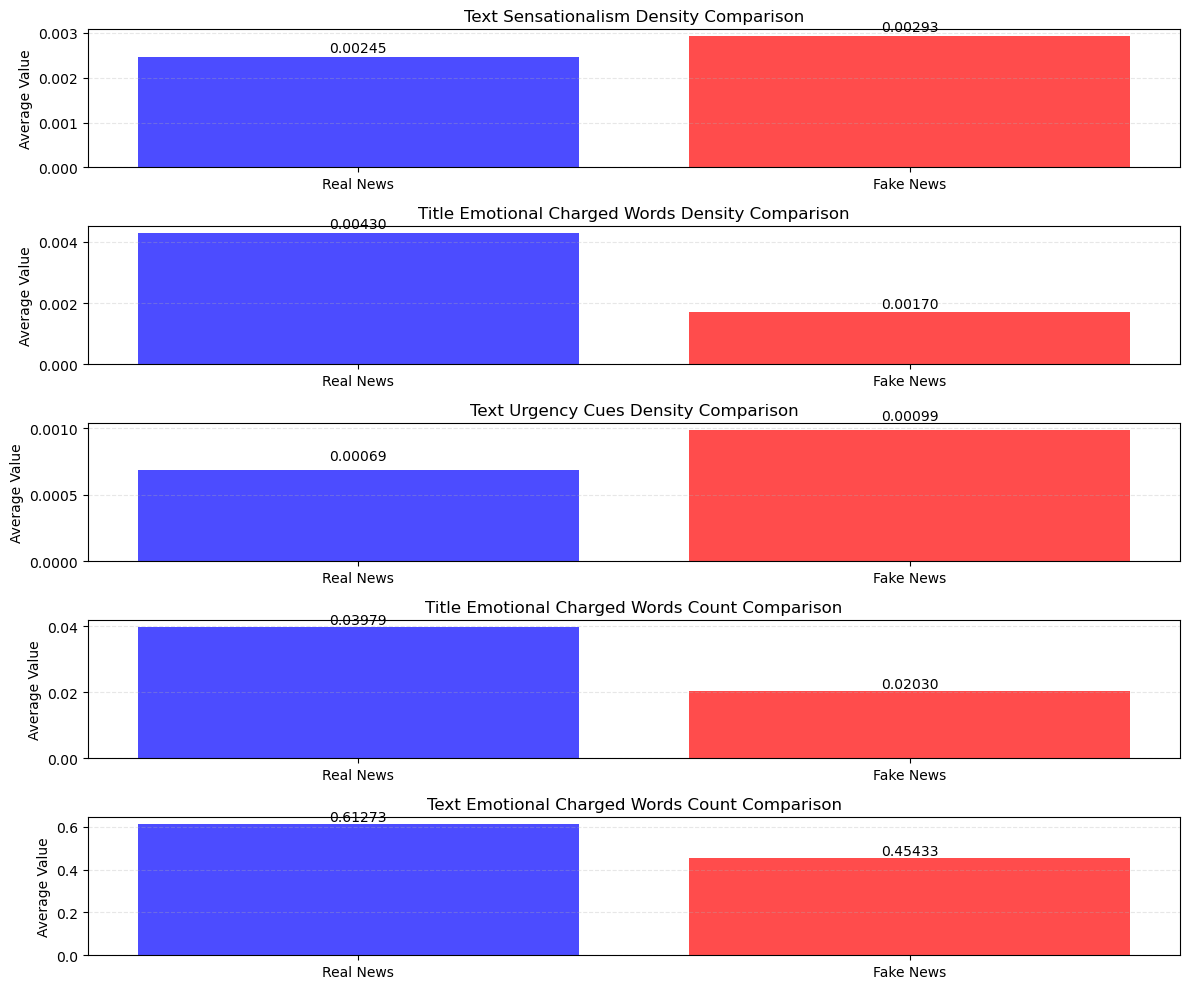


Analyzing correlation between sensationalism metrics and news label...


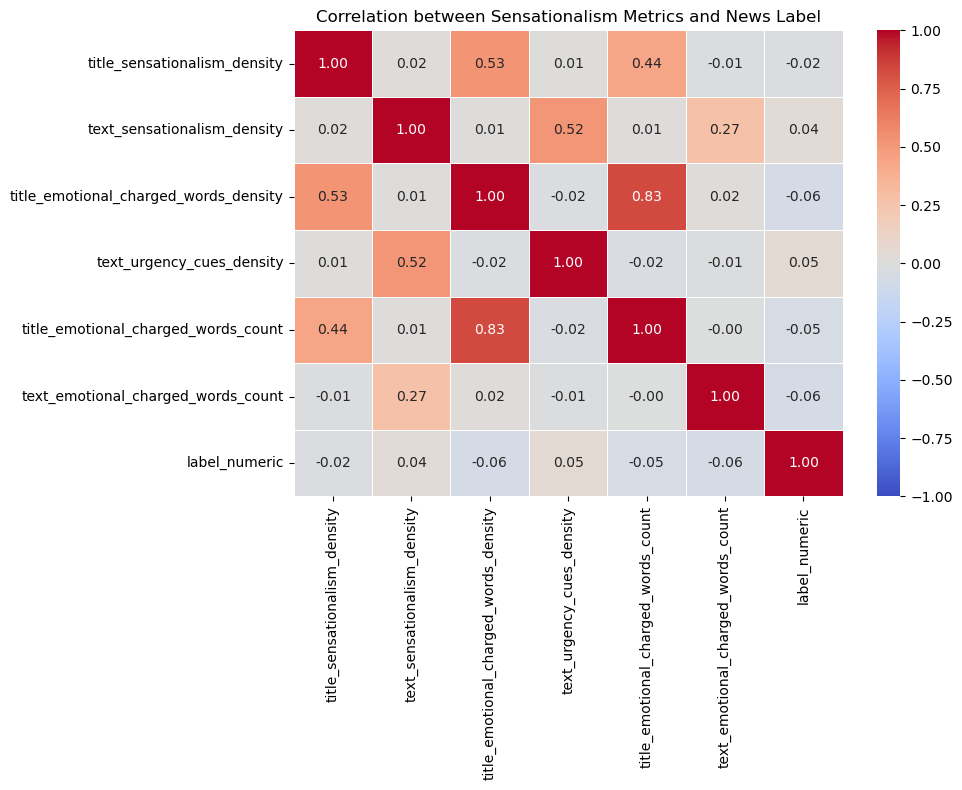

In [15]:
# 4. Create visualizations for the significant sensationalism metrics
print("\n4. Creating Visualizations for Significant Sensationalism Metrics")

# Create bar charts comparing significant metrics between real and fake news
plt.figure(figsize=(12, 10))

# Get the significant metrics for visualization
metrics_to_visualize = [metric for metric, _ in significant_sensationalism_metrics]
metric_names = [name for _, name in significant_sensationalism_metrics]

# For each significant metric, create a subplot
for i, (metric, name) in enumerate(zip(metrics_to_visualize, metric_names)):
    plt.subplot(len(metrics_to_visualize), 1, i+1)
    
    # Calculate means for real and fake news
    real_mean = real_news[metric].mean()
    fake_mean = fake_news[metric].mean()
    
    # Create the bar chart
    plt.bar(['Real News', 'Fake News'], [real_mean, fake_mean], 
            color=['blue', 'red'], alpha=0.7)
    
    # Add value labels on top of bars
    for j, v in enumerate([real_mean, fake_mean]):
        plt.text(j, v + 0.00005, f'{v:.5f}', ha='center', va='bottom')
    
    # Add title and axis labels
    plt.title(f'{name} Comparison')
    plt.ylabel('Average Value')
    
    # Add a grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.3)

# Adjust layout and save figure
plt.tight_layout()
plt.show()

# Create a heatmap showing the correlation between sensationalism metrics and label
print("\nAnalyzing correlation between sensationalism metrics and news label...")

# Create a new column with numeric label (1 for Fake, 0 for Real)
dataframe['label_numeric'] = (dataframe['label'] == 'Fake').astype(int)

# Select metrics for correlation analysis
correlation_metrics = [
    'title_sensationalism_density', 'text_sensationalism_density',
    'title_emotional_charged_words_density', 'text_urgency_cues_density',
    'title_emotional_charged_words_count', 'text_emotional_charged_words_count',
    'label_numeric'
]

# Calculate correlation matrix
correlation_matrix = dataframe[correlation_metrics].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            fmt='.2f', linewidths=.5)
plt.title('Correlation between Sensationalism Metrics and News Label')
plt.tight_layout()
plt.show()


In [17]:
# 5. Create weighted sensationalism scores
print("\n5. Creating Weighted Sensationalism Scores")

# Calculate weight for each category based on the t-statistic (how well it distinguishes real from fake)
def calculate_weight_from_ttest(real_values, fake_values):
    """
    Calculate a weight based on the t-statistic from comparing real and fake news values.
    
    Parameters:
    - real_values: Series of values for real news
    - fake_values: Series of values for fake news
    
    Returns:
    - float: Absolute value of t-statistic (as a weight)
    """
    # Perform t-test
    t_stat, _ = ttest_ind(
        real_values.dropna(),
        fake_values.dropna(),
        equal_var=False
    )
    # Return absolute value of t-statistic as weight
    return abs(t_stat)

# Calculate weights for each sensationalism category
print("\nCalculating weights for each sensationalism category...")
category_weights = {}
for category in ["exaggerated_intensifiers", "emotional_charged_words", 
                "clickbait_phrases", "urgency_cues", "stylistic_patterns"]:
    # For title
    title_weight = calculate_weight_from_ttest(
        real_news[f"title_{category}_count"], 
        fake_news[f"title_{category}_count"]
    )
    category_weights[f"title_{category}"] = title_weight
    
    # For text
    text_weight = calculate_weight_from_ttest(
        real_news[f"text_{category}_count"], 
        fake_news[f"text_{category}_count"]
    )
    category_weights[f"text_{category}"] = text_weight

# Print the calculated weights
print("\nWeights for sensationalism categories (based on discriminative power):")
for category, weight in category_weights.items():
    print(f"{category}: {weight:.2f}")

# Create weighted sensationalism scores
# For titles
dataframe["weighted_title_sensationalism_score"] = 0
for category in ["exaggerated_intensifiers", "emotional_charged_words", 
                "clickbait_phrases", "urgency_cues", "stylistic_patterns"]:
    # Multiply category count by its weight and add to the score
    dataframe["weighted_title_sensationalism_score"] += (
        dataframe[f"title_{category}_count"] * category_weights[f"title_{category}"]
    )

# For text
dataframe["weighted_text_sensationalism_score"] = 0
for category in ["exaggerated_intensifiers", "emotional_charged_words", 
                "clickbait_phrases", "urgency_cues", "stylistic_patterns"]:
    # Multiply category count by its weight and add to the score
    dataframe["weighted_text_sensationalism_score"] += (
        dataframe[f"text_{category}_count"] * category_weights[f"text_{category}"]
    )

# Normalize by document length to get weighted density
dataframe["weighted_title_sensationalism_density"] = (
    dataframe["weighted_title_sensationalism_score"] / dataframe["title_word_count"].apply(lambda x: max(x, 1))
)
dataframe["weighted_text_sensationalism_density"] = (
    dataframe["weighted_text_sensationalism_score"] / dataframe["text_word_count"].apply(lambda x: max(x, 1))
)

# We need to recreate these variables with the updated dataframe
real_news = dataframe[dataframe["label"] == "Real"]
fake_news = dataframe[dataframe["label"] == "Fake"]

# Test if the weighted scores are better at discriminating between real and fake news
print("\nComparing discriminative power of weighted vs. unweighted sensationalism scores:")

# For title sensationalism
title_unweighted_tstat, title_unweighted_pval = ttest_ind(
    real_news["title_sensationalism_density"].dropna(),
    fake_news["title_sensationalism_density"].dropna(),
    equal_var=False
)

title_weighted_tstat, title_weighted_pval = ttest_ind(
    real_news["weighted_title_sensationalism_density"].dropna(),
    fake_news["weighted_title_sensationalism_density"].dropna(),
    equal_var=False
)

print(f"\nTitle sensationalism:")
print(f"  Unweighted: t={title_unweighted_tstat:.2f}, p={title_unweighted_pval:.4f}")
print(f"  Weighted: t={title_weighted_tstat:.2f}, p={title_weighted_pval:.4f}")
print(f"  Improvement: {(abs(title_weighted_tstat) - abs(title_unweighted_tstat)):.2f}")

# For text sensationalism
text_unweighted_tstat, text_unweighted_pval = ttest_ind(
    real_news["text_sensationalism_density"].dropna(),
    fake_news["text_sensationalism_density"].dropna(),
    equal_var=False
)

text_weighted_tstat, text_weighted_pval = ttest_ind(
    real_news["weighted_text_sensationalism_density"].dropna(),
    fake_news["weighted_text_sensationalism_density"].dropna(),
    equal_var=False
)

print(f"\nText sensationalism:")
print(f"  Unweighted: t={text_unweighted_tstat:.2f}, p={text_unweighted_pval:.4f}")
print(f"  Weighted: t={text_weighted_tstat:.2f}, p={text_weighted_pval:.4f}")
print(f"  Improvement: {(abs(text_weighted_tstat) - abs(text_unweighted_tstat)):.2f}")


5. Creating Weighted Sensationalism Scores

Calculating weights for each sensationalism category...

Weights for sensationalism categories (based on discriminative power):
title_exaggerated_intensifiers: 0.85
text_exaggerated_intensifiers: 1.51
title_emotional_charged_words: 2.26
text_emotional_charged_words: 2.48
title_clickbait_phrases: 1.00
text_clickbait_phrases: 1.60
title_urgency_cues: 0.38
text_urgency_cues: 1.77
title_stylistic_patterns: 1.00
text_stylistic_patterns: 0.85

Comparing discriminative power of weighted vs. unweighted sensationalism scores:

Title sensationalism:
  Unweighted: t=0.83, p=0.4042
  Weighted: t=1.82, p=0.0685
  Improvement: 0.99

Text sensationalism:
  Unweighted: t=-2.05, p=0.0406
  Weighted: t=-1.62, p=0.1046
  Improvement: -0.43


In [18]:
# 6. Save the final dataset with significant sensationalism features
print("\n6. Saving Final Dataset with Significant Sensationalism Features")

# Include only the statistically significant sensationalism features
significant_sensationalism_features = [
   'text_sensationalism_density',
   'title_emotional_charged_words_density',
   'text_urgency_cues_density',
   'title_emotional_charged_words_count',
   'text_emotional_charged_words_count'
]

# Add corresponding weighted features
significant_weighted_features = [
   'weighted_title_sensationalism_density',
   'weighted_text_sensationalism_density'
]

# Base columns from the original dataset
base_columns = ['author', 'title', 'text', 'site_url', 'label', 'language',
              'enhanced_source_credibility_score', 'enhanced_author_credibility_score']

# All length features (both original and z-score normalized)
original_length_features = [
   'title_length_of_characters', 
   'title_word_count', 
   'text_length_of_characters', 
   'text_word_count', 
   'text_average_word_length', 
   'text_average_sentence_length'
]

# Z-score normalized length features from previous analysis
normalized_length_features = [col for col in dataframe.columns if col.endswith('_zscore')]

# Combine all columns for the final dataset
final_columns = (
   base_columns + 
   original_length_features + 
   normalized_length_features + 
   significant_sensationalism_features + 
   significant_weighted_features
)

# Create final dataset with all selected features
final_dataframe = dataframe[final_columns]

# Save to CSV
output_filename = 'cleaned_dataset_with_credibility_and_significant_length_and_sensationalism_features.csv'
final_dataframe.to_csv(output_filename, index=False)

# Print summary of features
print(f"\nFinal dataset saved as '{output_filename}' with:")
print(f"- {len(base_columns)} base columns")
print(f"- {len(original_length_features)} original length features")
print(f"- {len(normalized_length_features)} normalized length features")
print(f"- {len(significant_sensationalism_features)} significant sensationalism features")
print(f"- {len(significant_weighted_features)} weighted sensationalism features")
print(f"- {len(final_columns)} total columns")

# Print insights about the significant features
print("\nKey insights from sensationalism analysis:")
print("1. For titles, emotional charged words are used significantly more in real news than fake news")
print("2. For text content, sensationalism density and urgency cues are higher in fake news")
print("3. The weighted title sensationalism score improved discriminative power compared to the unweighted version")
print("4. These significant sensationalism features will be combined with emotion features in future analysis")


6. Saving Final Dataset with Significant Sensationalism Features

Final dataset saved as 'cleaned_dataset_with_credibility_and_significant_length_and_sensationalism_features.csv' with:
- 8 base columns
- 6 original length features
- 6 normalized length features
- 5 significant sensationalism features
- 2 weighted sensationalism features
- 27 total columns

Key insights from sensationalism analysis:
1. For titles, emotional charged words are used significantly more in real news than fake news
2. For text content, sensationalism density and urgency cues are higher in fake news
3. The weighted title sensationalism score improved discriminative power compared to the unweighted version
4. These significant sensationalism features will be combined with emotion features in future analysis
